In [54]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [55]:
df = pd.read_csv("C:/Users/Owner/Desktop/AlaskaProject/Data/modeldata.csv")

In [56]:
df.drop(['participant.code','question'],inplace = True, axis = 1)
df.rename(columns={'time__Red-eye':'time_redeye'}, inplace=True)

In [57]:
# Define output variable
y = df.choice_binary
# Drop output variable from dataset to form input vector
X = df.drop('choice_binary', axis=1)


# Use sklearn function train_test_split() to performa an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
# Verify shape of different sets
print("shape of original dataset :",df.shape)
print("shape of input - training set", X_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", X_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (5985, 48)
shape of input - training set (4788, 47)
shape of output - training set (4788,)
shape of input - testing set (1197, 47)
shape of output - testing set (1197,)


Test Logistic Regression w/ Regularization

In [58]:
C_values = [0.001,0.01,0.1,1,10,100,1000]
C_grid = {'C': C_values}

n_folds = 5


logistic = LogisticRegression(penalty='l1',max_iter = 500, solver = 'liblinear')
grid_logistic = GridSearchCV(logistic, C_grid, cv=n_folds, refit=True)
grid_logistic.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=500, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

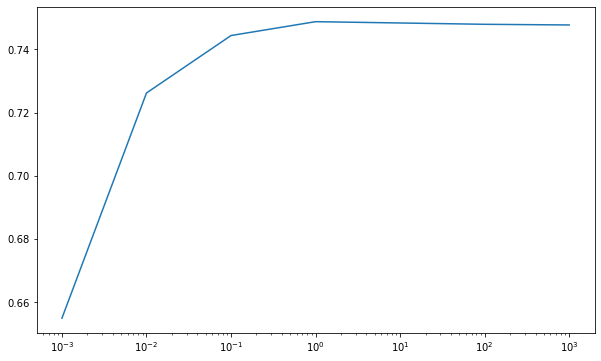

In [59]:
 # Visualize maximum accuracy
plt.figure().set_size_inches(10, 6)
fg2 = plt.semilogx(C_values, grid_logistic.cv_results_['mean_test_score'])
plt.savefig('figure_2.png')

In [60]:
 # Run the model on the test data
best_logistic = grid_logistic.best_estimator_
print(best_logistic.score(X_test,y_test))

0.7702589807852965


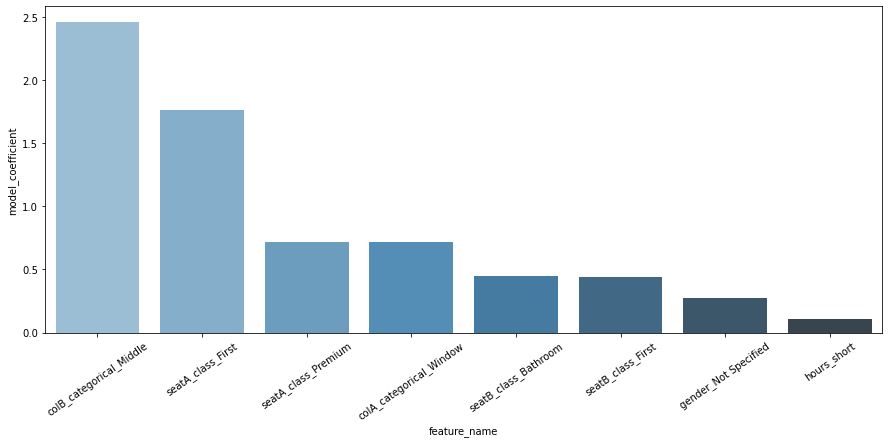

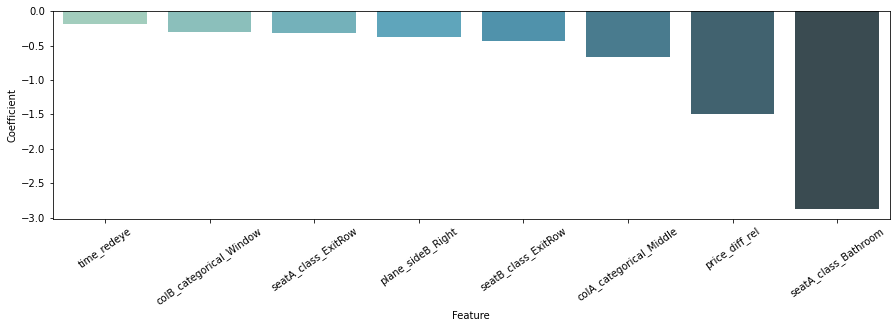

In [63]:
 # Get the models coefficients (and top 5 and bottom 5)
logistic_coeff = pd.DataFrame({'feature_name': X_train.columns, 'model_coefficient': best_logistic.coef_.transpose().flatten()})
logistic_coeff = logistic_coeff.sort_values('model_coefficient',ascending=False)
logistic_coeff_top = logistic_coeff.head(8)
logistic_coeff_bottom = logistic_coeff.tail(8)
# Plot top 5 coefficients
plt.figure().set_size_inches(15, 6)
fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logistic_coeff_top, palette="Blues_d")
fg3.set_xticklabels(rotation=35, labels=logistic_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(15,6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logistic_coeff_bottom, palette="GnBu_d")
fg4.set_xticklabels(rotation=35, labels=logistic_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
plt.savefig('figure_4.png')

In [64]:
y_pred_logistic = grid_logistic.predict(X_test)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

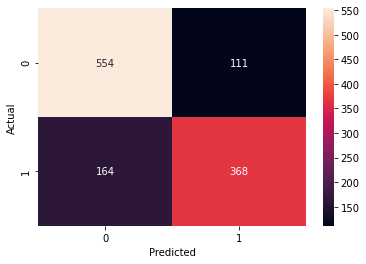

In [65]:
#Print Confusion Matrix
logistic_matrix = pd.crosstab(y_test, y_pred_logistic, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(logistic_matrix, annot=True, fmt='g')

In [66]:
#Print Classification Report
print(classification_report(y_test,y_pred_logistic))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       665
           1       0.77      0.69      0.73       532

    accuracy                           0.77      1197
   macro avg       0.77      0.76      0.76      1197
weighted avg       0.77      0.77      0.77      1197



Test XGBoost Model

In [67]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
print(xgb_model)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:57:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [68]:
# make predictions for test data
xgb_ypred = xgb_model.predict(X_test)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

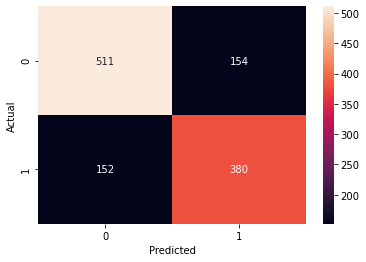

In [69]:
#Print Confusion Matrix
confusion_matrix_xgb = pd.crosstab(y_test, xgb_ypred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

In [70]:
#Print Classification Report
print(classification_report(y_test,xgb_ypred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       665
           1       0.71      0.71      0.71       532

    accuracy                           0.74      1197
   macro avg       0.74      0.74      0.74      1197
weighted avg       0.74      0.74      0.74      1197



In [71]:
import shap
shap.initjs()

In [72]:
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X)

i = 2156

shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.loc[2156], feature_names=X_train.columns)

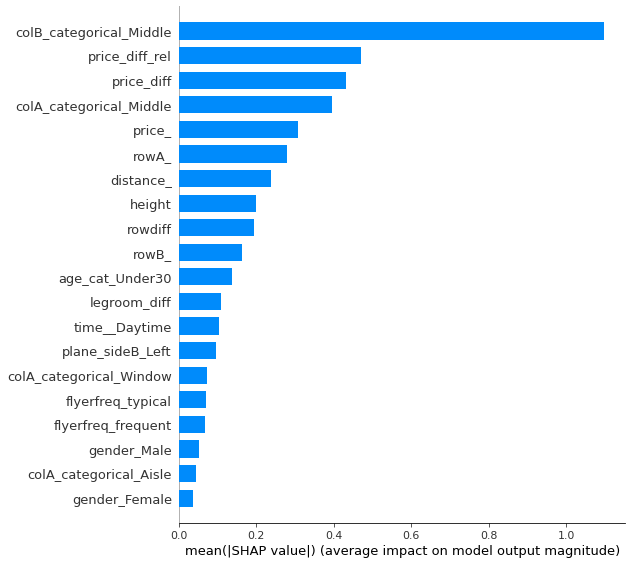

In [73]:
shap.summary_plot(shap_values, X, plot_type="bar")

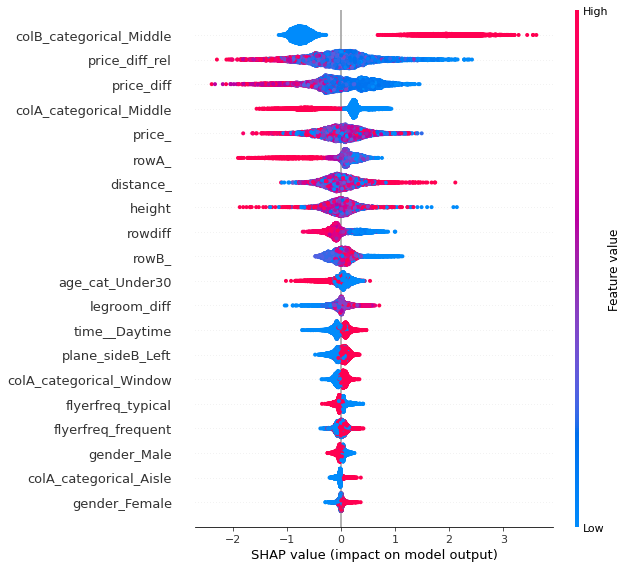

In [74]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

CART Model

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

In [76]:
def fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf, 
                                        random_state=0, 
                                  )
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_)
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file = None, 
                                feature_names = X.columns, 
                                class_names = [str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled = True, 
                                rounded = True, 
                                #rotate = True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph

In [77]:
def Plot_3D(X, X_test, y_test, clf, x1, x2, mesh_size, margin):
            
    # Specify a size of the mesh to be used
    mesh_size=mesh_size
    margin=margin

    # Create a mesh grid on which we will run our model
    x_min, x_max = X.iloc[:, 0].fillna(X.mean()).min() - margin, X.iloc[:, 0].fillna(X.mean()).max() + margin
    y_min, y_max = X.iloc[:, 1].fillna(X.mean()).min() - margin, X.iloc[:, 1].fillna(X.mean()).max() + margin
    xrange = np.arange(x_min, x_max, mesh_size)
    yrange = np.arange(y_min, y_max, mesh_size)
    xx, yy = np.meshgrid(xrange, yrange)
            
    # Calculate predictions on grid
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    # Create a 3D scatter plot with predictions
    fig = px.scatter_3d(x=X_test[x1], y=X_test[x2], z=y_test,
                     opacity=0.8, color_discrete_sequence=['black'])

    # Set figure title and colors
    fig.update_layout(#title_text="Scatter 3D Plot with CART Prediction Surface",
                      paper_bgcolor = 'white',
                      scene = dict(xaxis=dict(title=x1,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'),
                                   yaxis=dict(title=x2,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'
                                              ),
                                   zaxis=dict(title='Probability',
                                              backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0', 
                                              )))
    
    # Update marker size
    fig.update_traces(marker=dict(size=1))

    # Add prediction plane
    fig.add_traces(go.Surface(x=xrange, y=yrange, z=Z, name='CART Prediction',
                              colorscale='Jet',
                              reversescale=True,
                              showscale=False, 
                              contours = {"z": {"show": True, "start": 0.5, "end": 0.9, "size": 0.5}}))
    fig.show()
    return fig



In [78]:
# Fit model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X, y, 'gini', 'best', 
                                                       mdepth = 3, 
                                                       clweight = None,
                                                       minleaf = 50)

# Plot tree graph
graph

graph.render('Decision_Tree_all_vars_gini')


*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  3
No. of leaves:  8
No. of features:  47
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.7376775271512114
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       668
           1       0.76      0.59      0.67       529

    accuracy                           0.74      1197
   macro avg       0.74      0.72      0.72      1197
weighted avg       0.74      0.74      0.73      1197

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.7543859649122807
              precision    recall  f1-score   support

           0       0.72      0.89      0.80      2572
           1       0.82      0.60      0.69      2216

    accuracy                           0.75      4788
   macro avg       0.77      0.74   

'Decision_Tree_all_vars_gini.pdf'